<a href="https://colab.research.google.com/github/Untick/Selector_ObjDet/blob/Roman-Penzov-folder/%D0%A1%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_%D0%A0%D0%BE%D0%BC%D0%B0%D0%BD_%D0%9F%D0%B5%D0%BD%D0%B7%D0%BE%D0%B2_%D0%A8%D0%90%D0%93_3_05_06_23_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ШАГ 3.**
Мысли нарастающим итогом:
1.   Как и на шаге 1 для первоначального решения задачи не стал вычищать базу, а оставил только файлы формата jpg и jpeg. Некоторые папки (виды одежды) удалил целиком. А уже на заключительных шагах буду использовать "исправленную/актуализированную" базу.
2.   Также хочу пробовать следующий алгоритм:
  *   сначала первая нейронка должна определить категорию одежды, к которой относится"картинка клиента". И почему бы для этого не использовать для первого варианта обычные сверточные нейронные сети. Иначе возможно попробовать вариант проверки на выброс.
  *   второй вид нейронки - это вариационный автокодировщик, который надо реализовать для каждой категории отдельно. Почему то думается, что так проще и эффективнее.
3. Написать функцию подбора схожих изображений на основе encoder.predict, NearestNeighbors 


In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import zipfile

In [3]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Путь к архивному файлу
file_path = '/content/gdrive/MyDrive/test_230501.zip'

# Путь к директории, в которую нужно разархивировать файл
extract_path = '/content/selector'

# Разархивирование файла
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [5]:
# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/selector/test_230501/'

In [7]:
# Получение списка папок, находящихся по адресу в скобках
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 9, метки классов: ['dress  business', 'dress casual', 'dress homemade', 'dress solemn', 'shirt men', 'shirt women', 'sportswear women', 't-shirt men', 't-shirt women']


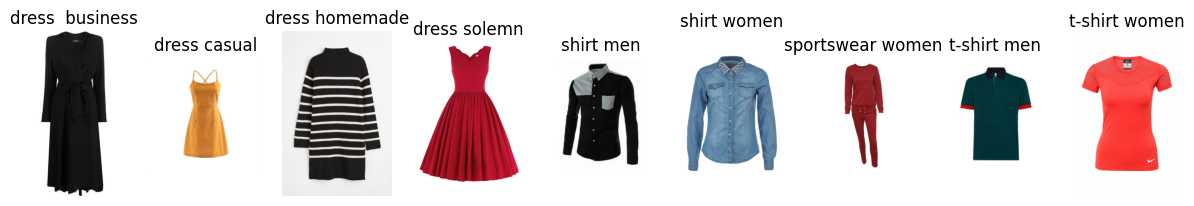

In [8]:
# Отобразим визуально для примера по одному изображению из каждого класса
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(15, 15))

# Для всех номеров классов:
for i in range(CLASS_COUNT):
    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'
    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path)) 
    # Отображение фотографии
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))  
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [9]:
# Загрузка и предобработка изображений из базы данных
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(
            os.path.join(folder, filename),
            target_size=(128, 128)  # Размер изображения для входа в автокодировщик
        )
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

In [10]:
# Создание списка категорий товаров
categories = ['dress  business']

# Загрузка изображений для каждой категории
image_data = {}
for category in categories:
    folder_path = os.path.join(IMAGE_PATH, category)  # Путь к папке с изображениями для данной категории
    images = load_images_from_folder(folder_path)
    image_data[category] = images

# Создание пустых списков для входных и выходных данных
X = []

# Добавление данных в списки
for category in categories:
    for image in image_data[category]:
        X.append(image)

# Преобразование списка в массив
X = np.array(X)

# Нормализация данных
X = X.astype('float32') / 255.

# Разделение данных на обучающую и тестовую выборки
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Изменение размера изображений до ожидаемой формы
resized_X_train = resize(X_train, (X_train.shape[0], 128, 128, 3))
resized_X_test = resize(X_test, (X_test.shape[0], 128, 128, 3))

In [11]:
# Создание модели автокодировщика
def build_vae(input_shape, latent_dim):
    # Кодировщик
    encoder_input = Input(shape=input_shape, name='encoder_input')
    x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_input)
    x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)

    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Сэмплирование из нормального распределения с параметрами z_mean и z_log_var
    def sampling(args):
        z_mean, z_log_var = args
        batch_size = tf.shape(z_mean)[0]
        epsilon = tf.random.normal(shape=(batch_size, latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, name='z')([z_mean, z_log_var])

    encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')

    # Декодер
    decoder_input = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(16, activation='relu')(decoder_input)
    x = Dense(32 * 32 * 64, activation='relu')(x)
    x = Reshape((32, 32, 64))(x)
    x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

    decoder = Model(decoder_input, x, name='decoder')

    # VAE
    vae_output = decoder(encoder(encoder_input)[2])
    vae = Model(encoder_input, vae_output, name='vae')

    return vae

In [12]:
# Построение модели автокодировщика с заданными параметрами
vae = build_vae(input_shape=(128, 128, 3), latent_dim=50)

# Компиляция модели
vae.compile(optimizer='adam', loss='mse')

In [13]:
# Обучение модели
history = vae.fit(
    resized_X_train,
    resized_X_train,
    epochs=50,
    batch_size=32,
    validation_data=(resized_X_test, resized_X_test)
)

Epoch 1/50
11/11 [==============================] - 17s 194ms/step - loss: 0.1791 - val_loss: 0.1105
Epoch 2/50
11/11 [==============================] - 0s 37ms/step - loss: 0.0879 - val_loss: 0.0796
Epoch 3/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0781 - val_loss: 0.0742
Epoch 4/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0737 - val_loss: 0.0711
Epoch 5/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0706 - val_loss: 0.0696
Epoch 6/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0700 - val_loss: 0.0692
Epoch 7/50
11/11 [==============================] - 0s 37ms/step - loss: 0.0685 - val_loss: 0.0676
Epoch 8/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0673 - val_loss: 0.0667
Epoch 9/50
11/11 [==============================] - 0s 37ms/step - loss: 0.0657 - val_loss: 0.0643
Epoch 10/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0622 - val_loss: 0.0596
Epoch 1

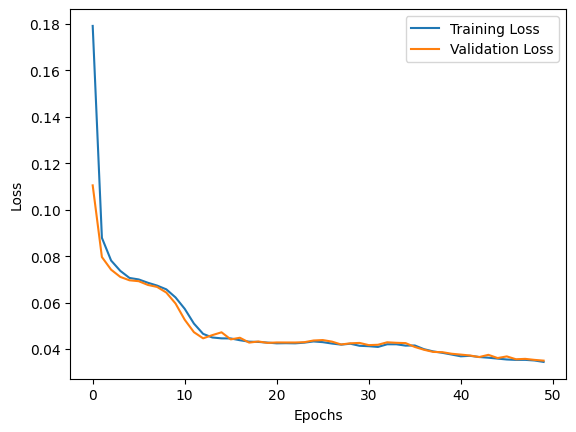

In [14]:
# Отображение графика ошибки
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# Использование обученного автокодировщика для восстановления изображений
test_image = tf.keras.preprocessing.image.load_img('/content/selector/test/19643235_43909388_1000.jpg', target_size=(128, 128))
test_image = tf.keras.preprocessing.image.img_to_array(test_image) / 255.0
test_image = tf.expand_dims(test_image, axis=0)
decoded_image = vae.predict(test_image)

1/1 [==============================] - 0s 21ms/step


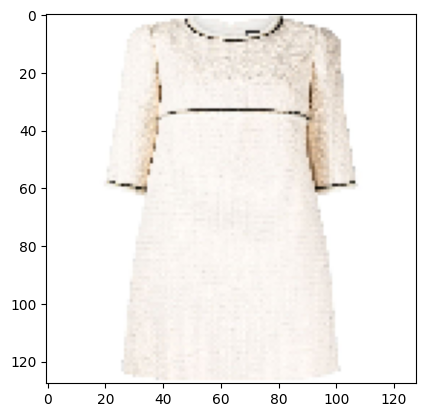

In [22]:
# Вывод исходного изображения
plt.imshow(test_image.numpy().reshape(128, 128, 3))
# Показать графики
plt.show()

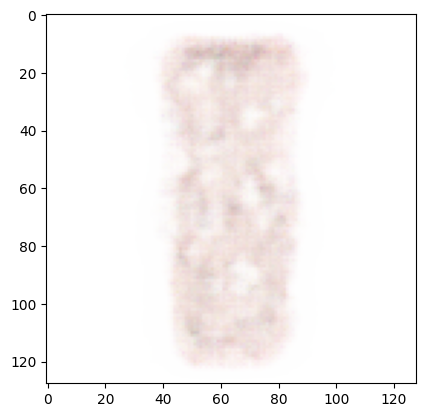

In [23]:
# Вывод полученного изображения
plt.imshow(decoded_image.reshape(128, 128, 3))

# Показать графики
plt.show()

In [24]:
# Использование обученного автокодировщика для восстановления изображений
test_image = tf.keras.preprocessing.image.load_img('/content/selector/test/18588512_40891810_1000.jpg', target_size=(128, 128))
test_image = tf.keras.preprocessing.image.img_to_array(test_image) / 255.0
test_image = tf.expand_dims(test_image, axis=0)
decoded_image = vae.predict(test_image)

1/1 [==============================] - 0s 122ms/step


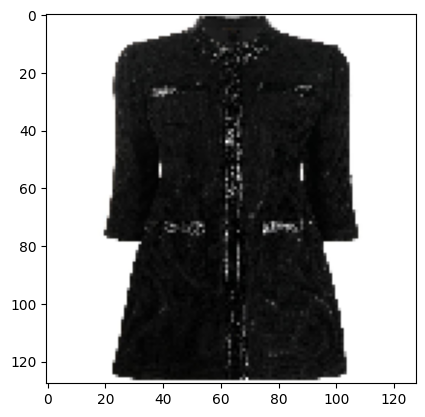

In [25]:
# Вывод исходного изображения
plt.imshow(test_image.numpy().reshape(128, 128, 3))
# Показать графики
plt.show()

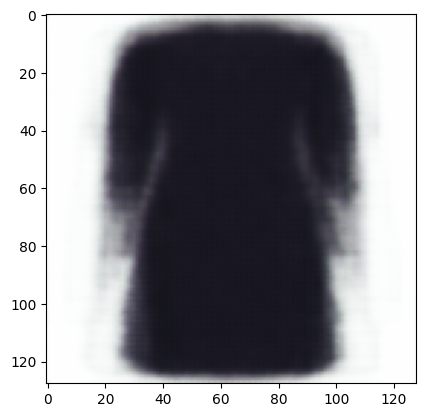

In [26]:
# Вывод полученного изображения
plt.imshow(decoded_image.reshape(128, 128, 3))

# Показать графики
plt.show()

In [27]:
# Использование обученного автокодировщика для восстановления изображений
test_image = tf.keras.preprocessing.image.load_img('/content/selector/test/18572872_40046775_1000.jpg', target_size=(128, 128))
test_image = tf.keras.preprocessing.image.img_to_array(test_image) / 255.0
test_image = tf.expand_dims(test_image, axis=0)
decoded_image = vae.predict(test_image)

1/1 [==============================] - 0s 66ms/step


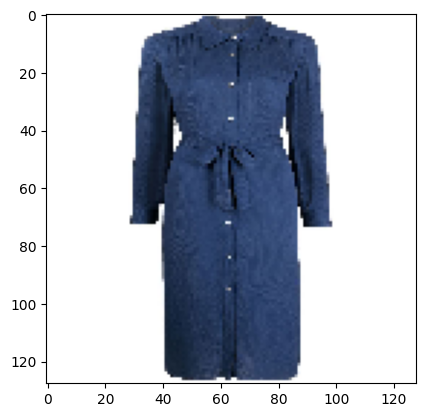

In [28]:
# Вывод исходного изображения
plt.imshow(test_image.numpy().reshape(128, 128, 3))
# Показать графики
plt.show()

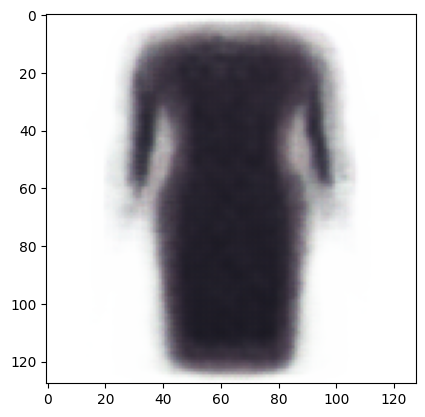

In [29]:
# Вывод полученного изображения
plt.imshow(decoded_image.reshape(128, 128, 3))

# Показать графики
plt.show()

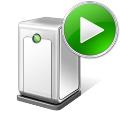

In [30]:
# NearestNeighbors из sklearn.neighbors используется для поиска ближайших соседей
from sklearn.neighbors import NearestNeighbors

In [40]:
# Функция для поиска схожих изображений
def find_similar_images(image_path, num_neighbors=5): # путь к изображению image_path и необязательный параметр num_neighbors (по умолчанию 5)
    # Загрузка и предобработка изображения
    test_image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    test_image = tf.keras.preprocessing.image.img_to_array(test_image) / 255.0
    test_image = np.expand_dims(test_image, axis=0) # расширяется по размерности 0, чтобы соответствовать ожидаемой форме входных данных модели
    
    # Получение кодировки изображения с помощью encoder.predict, используя слой encoder модели vae. 
    # Метод predict применяется к слою encoder и принимает тестовое изображение в качестве входных данных.
    # Результатом является предсказанная кодировка, из которой мы берем только z_mean (среднее значение)
    encoded_image = vae.get_layer('encoder').predict(test_image)[0]  # !!! Используем только z_mean
    
    # Создание экземпляра NearestNeighbors и подгонка с использованием всех кодировок обучающей выборки
    # Здесь мы создаем экземпляр класса NearestNeighbors с параметром n_neighbors,
    # указывающим количество ближайших соседей для поиска,
    # и указываем метрику 'euclidean' для вычисления расстояний между соседями.
    # Затем мы подгоняем модель nn с использованием кодировок обучающей выборки,
    # полученных с помощью слоя encoder модели vae.
    nn = NearestNeighbors(n_neighbors=num_neighbors, metric='euclidean')
    nn.fit(vae.get_layer('encoder').predict(resized_X_train)[0])  # !!! Используем только z_mean
    
    # Поиск ближайших соседей
    distances, indices = nn.kneighbors(encoded_image)
    
    # Вывод исходного изображения
    plt.imshow(test_image.reshape(128, 128, 3))
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
    
    # Вывод ближайших соседей
    fig, axs = plt.subplots(1, num_neighbors, figsize=(20, 20))
    
    for i, index in enumerate(indices[0]):
        similar_image = resized_X_train[index].reshape(128, 128, 3)
        axs[i].imshow(similar_image)
        axs[i].set_title(f'Similar Image {i+1}')
        axs[i].axis('off')
    
    plt.show()

11/11 [==============================] - 0s 5ms/step


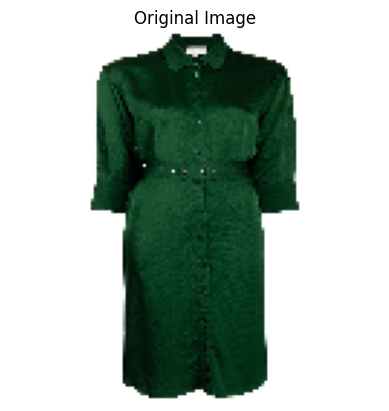

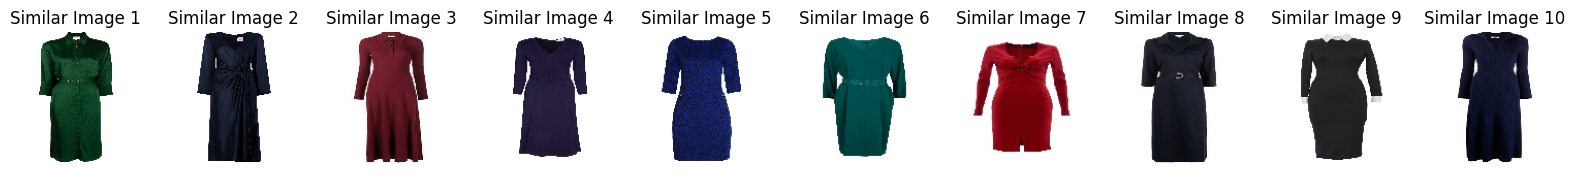

In [41]:
# Пример использования функции
image_path = '/content/selector/test/17259324_35784367_1000.jpg'
find_similar_images(image_path, num_neighbors=10)

11/11 [==============================] - 0s 5ms/step


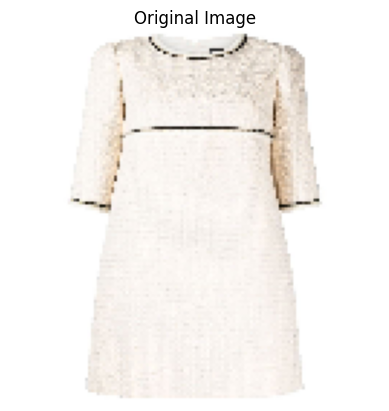

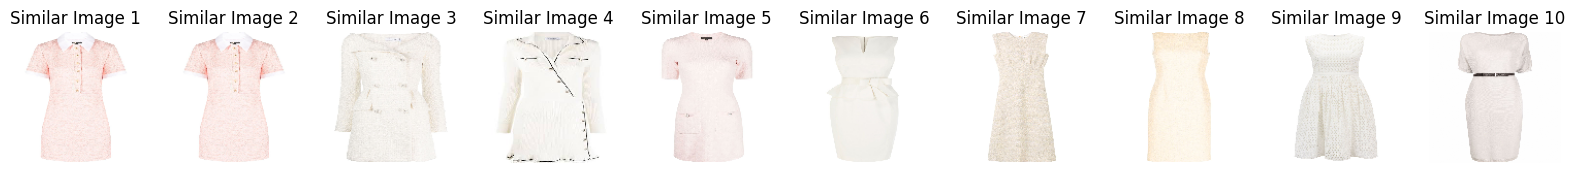

In [42]:
# Пример использования функции
image_path = '/content/selector/test/19643235_43909388_1000.jpg'
find_similar_images(image_path, num_neighbors=10)